In [1]:
import time

import imageio
import collections

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

%matplotlib inline

In [2]:
def animate(mass, position):
    image = np.zeros((1024, 1024))
    position = np.round(position).astype(np.int32)
    mass = mass.astype(np.int32)
        
    for i in range(len(mass)):
        temp_position = position[i]
        temp_mass = mass[i][0]

        image[np.maximum(temp_position[0] - temp_mass//2, 0) : np.minimum(temp_position[0] + temp_mass//2, 1024), 
              np.maximum(temp_position[1] - temp_mass//2, 0) : np.minimum(temp_position[1] + temp_mass//2, 1024)] = 255
        image = np.uint8(np.clip(image, 0, 255))
    
    file = BytesIO()
    PIL.Image.fromarray(image).save(file, 'jpeg')
    clear_output(wait = True)
    display(Image(data=file.getvalue()))

    return image

In [3]:
DIMENSIONS = 2

In [4]:
m = np.array([[10], [20], [2]])
x = np.array([[1, 2], [2, 4], [1, 4]])
x = x[:, None, :]

r = x - x.transpose(1, 0, 2)
r_magnitude = np.sqrt(np.sum(np.square(r), axis=2))
r_hat = r / np.expand_dims(r_magnitude, axis=2)

f = np.matmul(m, m.T) - np.diag(m.reshape((-1)) ** 2)
f = f / np.square(r_magnitude)

f = np.nansum(np.multiply(np.expand_dims(f, axis=2), r_hat), axis=1)

/home/bhagyesh/envs/research/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/bhagyesh/envs/research/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [5]:
f

array([[-17.88854382, -40.77708764],
       [ 57.88854382,  35.77708764],
       [-40.        ,   5.        ]])

In [6]:
f_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)
v_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)
x_initial = tf.placeholder(shape=[None, DIMENSIONS], dtype=tf.float32)

force = tf.Variable(f_initial, dtype=tf.float32, validate_shape=False)

m = tf.placeholder(shape=[None, 1], dtype=tf.float32)

G = tf.constant(6.67259, dtype=tf.float32)

acceleration = tf.Variable(tf.zeros_like(f_initial), validate_shape=False)
velocity = tf.Variable(v_initial, dtype=tf.float32, validate_shape=False)
position = tf.Variable(x_initial, dtype=tf.float32, validate_shape=False)

t_h = tf.placeholder(shape=[], dtype=tf.float32)
t_s = tf.placeholder(shape=[], dtype=tf.int32)

t = tf.Variable(0, dtype=tf.int32)

In [11]:
def loop_condition(i, p):
    return i < p.t_s

def loop_body(i, p):
    is_collide = tf.logical_or(p.x < p.m / 2.0, p.x > 1024 - p.m / 2.0)
    
    x = tf.expand_dims(p.x, axis=1)
    r = x - tf.transpose(x, perm=[1, 0, 2])
    r_magnitude = tf.sqrt(tf.reduce_sum(tf.square(r), axis=2))
    r_hat = -r / tf.expand_dims(r_magnitude, axis=2)
    
    f = tf.matmul(p.m, tf.transpose(p.m)) - tf.diag(tf.square(tf.reshape(p.m, shape=[-1])))
    f = f * p.G
    f = f / tf.square(r_magnitude)
    f = tf.multiply(tf.expand_dims(f, axis=2), r_hat)
    
    f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)
    f = tf.reduce_sum(f, axis=1)

    f_ = f
    
    a_ = f_ / p.m

    v_ = p.v + a_ * p.t_h

    x_ = p.x + v_ * p.t_h

    return i + 1, Pair(f_, p.m, a_, v_, x_, p.G, p.t_h, p.t_s)

Pair = collections.namedtuple('Pair', 'f, m, a, v, x, G, t_h, t_s')
loop_vars = (t, Pair(force, m, acceleration, velocity, position, G, t_h, t_s))

simulate = tf.while_loop(loop_condition, loop_body, loop_vars=loop_vars)

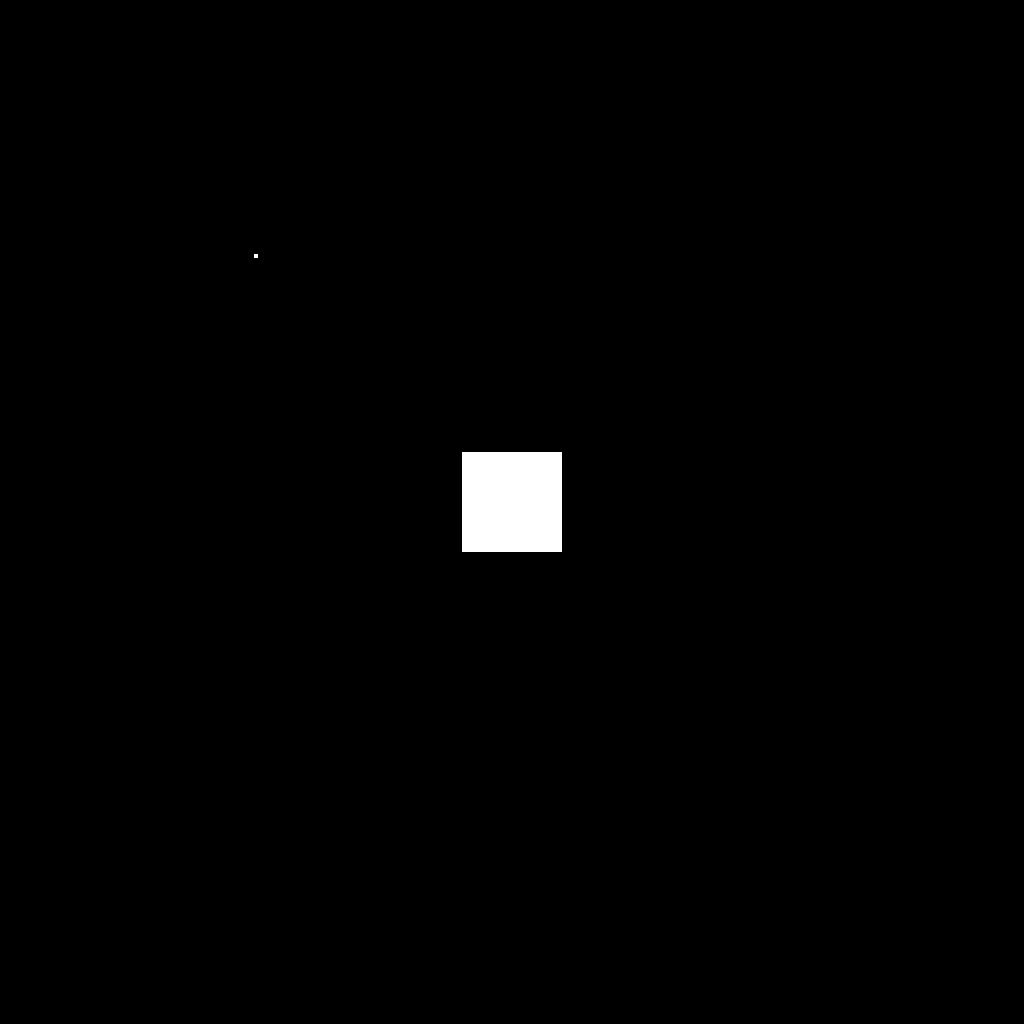

140.90071845054626


In [16]:
start_time = time.time()

force_0 = np.array([[0.0, 0.0], [0.0, 0.0]], dtype=np.float32)
velocity_0 = np.array([[-1.0, 0.0], [0.0, 0.0]], dtype=np.float32)
position_0 = np.array([[512, 512], [256, 256]])

mass = np.array([[100], [5]])
time_horizon = 0.1
number_horizon = int(10 / time_horizon)

gif_frames = []

with tf.Session() as sess:
    for i in range(number_horizon):
        sess.run(tf.global_variables_initializer(), 
                 feed_dict={f_initial:force_0, 
                            v_initial:velocity_0, 
                            x_initial:position_0})
        temp = sess.run(simulate, feed_dict={m:mass, t_h:time_horizon, t_s:i})
        print(temp[1].f)
        animate(mass, temp[1].x)
        
execution_time = time.time() - start_time
print(execution_time)